In [1]:
import time
import json
import asyncio
import concurrent.futures
import requests
import matplotlib.pyplot as plt

CONCURRENCY_LEVEL = 11

In [5]:
def check_status(receipt_num):
    #print(receipt_num)
    pload = {"appReceiptNum": receipt_num, "initCaseSearch":"CHECK STATUS"}
    r = requests.post('https://egov.uscis.gov/casestatus/mycasestatus.do', data=pload)
    if (r.status_code != 200):
        print("Error with {0}, code {1}".format(receipt_num, r.status_code))
        return None
    
    # spliting "\n" rather than do html decoding is for performance consideration.
    # splitting "\n" and goes directly to the line is much more faster than
    # html decoding and regex matching
    response = r.text.split("\n")
    
    ## leave this printing for quickly figure out which line is status 
    ## since uscis changes the format constantly
    # for x in range(715,725):
    #    print(x, response[x].strip())
    return (receipt_num, response[719].strip())
    
    
def save_plot(status_list):
    x, y = zip(*status_list)
    plt.scatter(x, y)
    plt.show()
    plt.savefig('UscisStats.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [3]:
with open('today.json') as f:
    yday = json.load(f)
with open('yday.json','w') as f:
    json.dump(yday, f)
    
len(yday)

1480

<Task pending name='Task-2' coro=<main() running at <ipython-input-6-3d908c1e23c2>:5>>

Running total 134 batches
 - processing batch No.0, the job has took 0.00 seconds.
 - processing batch No.10, the job has took 4.79 seconds.
 - processing batch No.20, the job has took 9.72 seconds.
 - processing batch No.30, the job has took 14.78 seconds.
 - processing batch No.40, the job has took 19.41 seconds.
 - processing batch No.50, the job has took 24.24 seconds.
 - processing batch No.60, the job has took 29.03 seconds.
 - processing batch No.70, the job has took 34.16 seconds.
 - processing batch No.80, the job has took 39.03 seconds.
 - processing batch No.90, the job has took 43.93 seconds.
 - processing batch No.100, the job has took 48.50 seconds.
 - processing batch No.110, the job has took 53.22 seconds.
 - processing batch No.120, the job has took 58.02 seconds.
 - processing batch No.130, the job has took 62.61 seconds.
1480


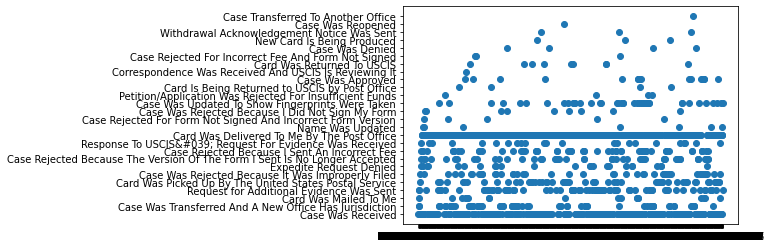

In [6]:
status_list = []

#yday=[('EAC2090108729', ''), ('EAC2090114277', '')]

async def main():

    loop = asyncio.get_event_loop()
    batches = int(len(yday)/CONCURRENCY_LEVEL)
    print("Running total {} batches".format(batches))
    start = time.time()
    for i in range(batches):
        if i % 10 == 0:
            seconds = time.time() - start
            print(" - processing batch No.{0}, the job has took {1:.2f} seconds.".format(i, seconds))
        
        batch_start = CONCURRENCY_LEVEL * i
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=CONCURRENCY_LEVEL) as executor:
            
            futures = [
                loop.run_in_executor(
                    executor,
                    check_status,
                    yday[batch_start+x][0]
                )
                for x in range(CONCURRENCY_LEVEL)
            ]
            for t in await asyncio.gather(*futures):
                if t is not None:
                    status_list.append(t)
    
    
    if batches*CONCURRENCY_LEVEL < len(yday):
        batch_start = CONCURRENCY_LEVEL * batches
        batch_num = len(yday) - CONCURRENCY_LEVEL * batches
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=batch_num) as executor:
            futures = [
                loop.run_in_executor(
                    executor,
                    check_status,
                    yday[batch_start+x][0]
                )
                for x in range(batch_num)
            ]
            for t in await asyncio.gather(*futures):
                if t is not None:
                    status_list.append(t)
                    
    print(len(status_list))

    save_plot(status_list)


loop = asyncio.get_event_loop()
loop.create_task(main())

In [7]:
APPROVED = set([
    'Card Was Mailed To Me',
    'Case Was Approved',
    'New Card Is Being Produced',
    'Card Was Picked Up By The United States Postal Service',
    'Card Is Being Returned To USCIS by Post Office',
    'Card Was Returned To USCIS',
    'Card Was Delivered To Me By The Post Office',
])

NOT_PROCESSED = set([
    'Case Was Received',
    'Case Was Updated To Show Fingerprints Were Taken',
    'Expedite Request Received',
    'Expedite Request Denied',
    'Date of Birth Was Updated',
    'Name Was Updated'
])

def statistic(print_details=True):
    diff = []
    approved = []
    not_processed = []
    rejected = []
    for i in range(len(yday)):
        if (yday[i][1] != status_list[i][1]):
            diff.append((yday[i][0], yday[i][1], status_list[i][1]))
        if (status_list[i][1].strip() in APPROVED):
            approved.append(status_list[i])
        if (status_list[i][1].strip() in NOT_PROCESSED):
            not_processed.append(status_list[i])
        if 'Rejected' in status_list[i][1].strip() or status_list[i][1].strip() == 'Case Was Denied':
            rejected.append(status_list[i])
    
    print('Case Changed total: {}'.format(len(diff)))
    if print_details:
        for case_num, s_from, s_to in diff:
            print(" - Case: {0}, status changed from {1} to {2}".format(case_num, s_from, s_to))
    
    print('Case Approved total: {0}, takes {1:.2f}% of {2} cases'.format(len(approved), len(approved)*100/len(yday), len(yday)))
    if print_details:
        for case_num, ap_status in approved:
            print(' - ' + case_num, ap_status)
        
    print('Case Not Processed total: {0}, takes {1:.2f}% of {2} cases'.format(len(not_processed), len(not_processed)*100/len(yday), len(yday)))
    print('Case Rejected total: {0}, takes {1:.2f}% of {2} cases'.format(len(rejected), len(rejected)*100/len(yday), len(yday)))

    
    not_counted = []
    
    if print_details:
        for i in range(len(status_list)):
            if (status_list[i] not in approved and \
                status_list[i] not in not_processed and \
                status_list[i] not in rejected):
                not_counted.append(status_list[i])
        print('Case Not Counted total: {0}, takes {1:.2f}% of {2} cases'.format(len(not_counted), len(not_counted)*100/len(yday), len(yday)))
        for case_num, ap_status in not_counted:
            print(' - ' + case_num, ap_status)
            
    print(len(approved) + len(rejected) + len(not_processed) + len(not_counted))

    
        
statistic(True)

Case Changed total: 862
 - Case: EAC2090108755, status changed from Case Was Received to Request for Additional Evidence Was Sent
 - Case: EAC2090108760, status changed from Case Was Received to Request for Additional Evidence Was Sent
 - Case: EAC2090108771, status changed from Case Was Received to Case Was Transferred And A New Office Has Jurisdiction
 - Case: EAC2090108772, status changed from Case Was Received to Card Was Picked Up By The United States Postal Service
 - Case: EAC2090108835, status changed from Case Was Received to Response To USCIS&#039; Request For Evidence Was Received
 - Case: EAC2090108836, status changed from Response To USCIS&#039; Request For Evidence Was Received to Card Was Delivered To Me By The Post Office
 - Case: EAC2090108849, status changed from Case Was Received to Expedite Request Denied
 - Case: EAC2090108869, status changed from Case Was Received to Card Was Delivered To Me By The Post Office
 - Case: EAC2090108910, status changed from Case Was R

 - EAC2090110646 Card Was Delivered To Me By The Post Office
 - EAC2090110651 Card Was Delivered To Me By The Post Office
 - EAC2090110652 Card Was Delivered To Me By The Post Office
 - EAC2090110653 Card Was Delivered To Me By The Post Office
 - EAC2090110656 Card Was Delivered To Me By The Post Office
 - EAC2090110658 Card Was Delivered To Me By The Post Office
 - EAC2090110672 Card Was Delivered To Me By The Post Office
 - EAC2090110680 Card Was Delivered To Me By The Post Office
 - EAC2090110681 Card Was Picked Up By The United States Postal Service
 - EAC2090110686 Card Was Delivered To Me By The Post Office
 - EAC2090110745 Card Was Delivered To Me By The Post Office
 - EAC2090110746 Card Was Delivered To Me By The Post Office
 - EAC2090110748 Card Was Picked Up By The United States Postal Service
 - EAC2090110750 Card Was Picked Up By The United States Postal Service
 - EAC2090110751 Card Was Delivered To Me By The Post Office
 - EAC2090110752 Card Was Picked Up By The United St

 - EAC2090109632 Case Was Transferred And A New Office Has Jurisdiction
 - EAC2090109633 Case Was Transferred And A New Office Has Jurisdiction
 - EAC2090109644 Case Was Transferred And A New Office Has Jurisdiction
 - EAC2090109646 Case Was Transferred And A New Office Has Jurisdiction
 - EAC2090109651 Case Was Transferred And A New Office Has Jurisdiction
 - EAC2090109652 Case Was Transferred And A New Office Has Jurisdiction
 - EAC2090109657 Case Was Transferred And A New Office Has Jurisdiction
 - EAC2090109725 Case Was Transferred And A New Office Has Jurisdiction
 - EAC2090109746 Case Was Transferred And A New Office Has Jurisdiction
 - EAC2090109802 Case Was Transferred And A New Office Has Jurisdiction
 - EAC2090109803 Case Was Transferred And A New Office Has Jurisdiction
 - EAC2090109804 Case Was Transferred And A New Office Has Jurisdiction
 - EAC2090109812 Case Was Transferred And A New Office Has Jurisdiction
 - EAC2090109829 Response To USCIS&#039; Request For Evidence Wa

<Figure size 432x288 with 0 Axes>

In [8]:
with open('today.json','w') as f:
    json.dump(status_list, f)
    
len(status_list)
    

1480